# Training

Let's try our hand in training a CNN

In [ ]:
!pip install torch torchvision scipy matplotlib numpy

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define a CNN model for MNIST
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Define data transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load MNIST data
mnist_train = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# Use Data Loader
train_loader = DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=100, shuffle=False)

# Instantiate the CNN model
cnn_model = CNNModel()

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = optim.SGD(cnn_model.parameters(), lr=learning_rate)

# Define accuracy function
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Training loop
total_epochs = 5
for epoch in range(total_epochs):
    for images, labels in train_loader:
        outputs = cnn_model(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, total_epochs, loss.item()))

# Evaluation
#cnn_model.eval()
with torch.no_grad():
    accum_acc = 0
    for images, labels in test_loader:
        outputs = cnn_model(images)

        loss = loss_fn(outputs, labels)
        acc = accuracy(outputs, labels)
        accum_acc += acc

    print('Test loss: {:.4f}, Test accuracy: {:.4f}'.format(loss.item(), accum_acc/len(test_loader)))

Epoch [1/5], Loss: 0.7850
Epoch [2/5], Loss: 0.4941
Epoch [3/5], Loss: 0.4238
Epoch [4/5], Loss: 0.4913
Epoch [5/5], Loss: 0.4813
Test loss: 0.4732, Test accuracy: 0.8098


## Data Augmentation

Can we train a CNN mdoel on a relatively small dataset ? What happens if the dataset is small ?

It is possible to train on a small dataset, and quite accurate too. However there is one major problem, if the input image differs, for example, it's upside down, the model will fail. This is known as overfitting. Overfitting occurs when a model learns to perform well on the training data but fails to generalize to unseen data.

To overcome this issue, we can use data augmentation. What is Data augmentation ?

Basically we artificially increase the size and diversity of the training dataset. We can do this by:
- Rotation: Data augmentation can involve rotating the digit images by various angles. This helps the model learn to recognize digits even if they are slightly tilted or rotated when written by different people.
- Scaling and Shearing: You can apply transformations that stretch or compress the digit images in both the x and y directions. This allows the model to handle variations in digit size and aspect ratio.
- Translation: Shifting the digit images within the image frame helps the model learn to recognize digits in different positions on the input image.
- Noise: Adding random noise to the images simulates variations in writing style and drawing imperfections.


Let's assume we want to make sure that make sure that our CNN model based on the MNIST dataset to recognize digits written by various individuals with different writing styles. Here's what we could do:

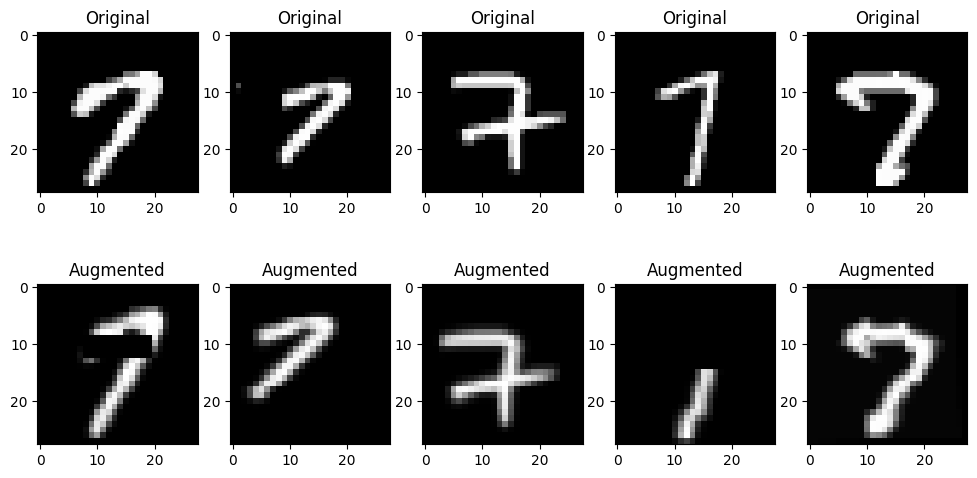

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Example data augmentation transformations
data_augmentation = transforms.Compose([
    transforms.RandomRotation(degrees=(-10, 10), fill=0),  # Fill with black for rotation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(size=(28, 28), scale=(0.8, 1.2)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomErasing(p=0.5),
])

# Create a custom dataset class to store augmented data
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, data_augmentation):
        self.original_dataset = original_dataset
        self.data_augmentation = data_augmentation

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, label = self.original_dataset[idx]
        augmented_image = self.data_augmentation(image)
        return augmented_image, label

# Create an augmented dataset
augmented_dataset = AugmentedDataset(train_dataset, data_augmentation)

# Choose a digit class (e.g., digit 7)
digit_class = 7

# Filter the dataset to get images of the chosen class
digit_images = [image for image, label in train_dataset if label == digit_class]

# Apply data augmentation to the images and convert to PIL Images
augmented_images_pil = [transforms.ToPILImage()(data_augmentation(image)) for image in digit_images]

# Convert PIL Images to NumPy arrays before visualization
original_images_np = [image.squeeze().numpy() for image in digit_images]
augmented_images_np = [np.array(image) for image in augmented_images_pil]

# Visualize original and augmented images
plt.figure(figsize=(12, 6))

for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(original_images_np[i], cmap='gray')
    plt.title("Original")

for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(augmented_images_np[i], cmap='gray')
    plt.title("Augmented")

plt.show()


How do we combine them ? We can use ConcatDataset

In [ ]:
from torch.utils.data import ConcatDataset

# Assuming you have a dataset object, e.g., mnist_train
num_images = len(train_dataset)
print("Number of images in the dataset (before):", num_images)

# Combine the original and augmented datasets
combined_dataset = ConcatDataset([train_dataset, augmented_dataset])

# Create a DataLoader for the combined dataset
combined_train_loader = DataLoader(combined_dataset, batch_size=100, shuffle=True)

# Assuming you have a dataset object, e.g., mnist_train
num_images = len(combined_dataset)
print("Number of images in the dataset (after):", num_images)

Number of images in the dataset (before): 60000
Number of images in the dataset (after): 120000


Next we can train them as usual. Pretty neat, eh ?

## Exercise CNN Training

In [ ]:
!pip install rggrader

In [ ]:
# @title #### Student Identity
student_id = "student_id" # @param {type:"string"}
name = "your_name" # @param {type:"string"}

In [ ]:
# @title #### 00. CNN Model using SHVN Dataset

from rggrader import submit
from datasets import load_dataset
# TODO: Train a model on your own, using the SVHN (Street View House Numbers) dataset :: https://huggingface.co/datasets/svhn
from datasets import load_dataset

dataset = load_dataset("svhn")
# You may add any code here to derive your variables
# Please change this
accuracy = 0

print(f"The accuracy is {accuracy}")


# Submit Method
assignment_id = "03_cnn"
question_id = "01_training_svhn"
#submit(student_id, name, assignment_id, str(accuracy), question_id, "")